In [267]:
!pip install surprise

In [268]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

from collections import defaultdict

# for implementing cross validation
from surprise.model_selection import KFold

In [269]:
rating = pd.read_csv('C:\\Users\\NEXUS\\Downloads\\ratings.csv')

In [270]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [271]:
rating = rating.drop(['timestamp'], axis=1)


In [272]:
plt.figure(figsize = (12, 4))

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

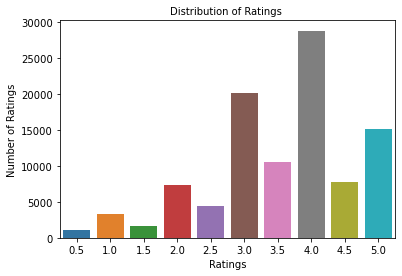

In [273]:
sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [274]:
rating['userId'].nunique()

671

In [275]:
rating['movieId'].nunique()


9066

In [276]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [277]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

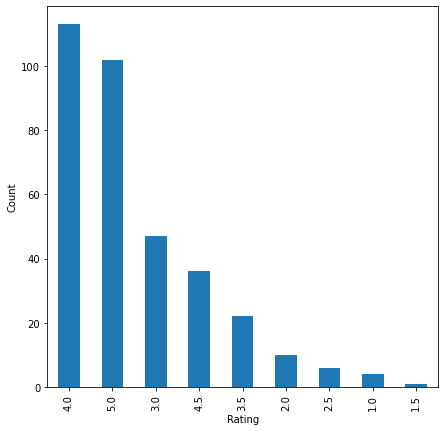

In [278]:
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

In [279]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
444      20
438      20
583      20
249      20
399      20
Name: userId, Length: 671, dtype: int64

In [280]:
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

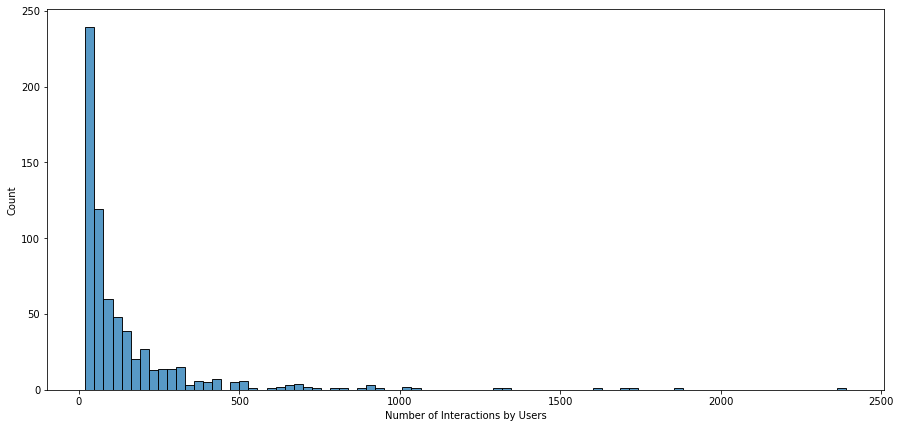

In [281]:
#Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))
#remove _______ and complete the code

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

In [282]:
#remove _______ and complete the code

#Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

#Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [283]:
final_rating.head()


,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [284]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

In [285]:
list(top_n_movies(final_rating, 5, 50))

[858, 318, 913, 1221, 50]

In [286]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

In [287]:
list(top_n_movies(final_rating, 5, 200))

[318, 50, 527, 608, 296]

In [288]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [289]:
#remove _______ and complete the code

#defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

#predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9672


0.9671524784958385

In [290]:
#remove _______ and complete the code
algo_knn_user.predict(0, 10, r_ui=4, verbose=True)

user: 0          item: 10         r_ui = 4.00   est = 3.55   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid=0, iid=10, r_ui=4, est=3.5459045285801785, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [291]:
#remove _______ and complete the code
algo_knn_user.predict(4, 10, verbose=True)

user: 4          item: 10         r_ui = None   est = 3.68   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=None, est=3.680292946370331, details={'actual_k': 40, 'was_impossible': False})

In [292]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
grid_obj= GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting the data
grid_obj.fit(data)

# best RMSE score
print(grid_obj.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9648832882847516
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [293]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.967765,0.965511,0.961374,0.964883,0.002647,1,0.744427,0.743007,0.737927,0.741787,0.002790,1,0.241686,0.003391,2.948778,0.356417,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.995019,0.994047,0.989707,0.992925,0.002309,13,0.769828,0.768127,0.763453,0.767136,0.002695,12,0.796203,0.000940,3.028897,0.289348,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.972187,0.969728,0.963976,0.968630,0.003441,3,0.747299,0.745933,0.740628,0.744620,0.002877,3,0.211102,0.005777,3.138936,0.350471,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.998523,0.996769,0.990968,0.995420,0.003228,15,0.771778,0.769781,0.765195,0.768918,0.002756,15,1.221732,0.132741,3.194122,0.177561,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.977333,0.974995,0.969801,0.974043,0.003148,7,0.751705,0.750883,0.745477,0.749355,0.002763,6,0.236699,0.042659,2.868327,0.033208,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


In [294]:
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9908


0.9907613369496804

In [295]:
#remove _______ and complete the code
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

In [296]:
#remove _______ and complete the code
similarity_algo_optimized_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

In [297]:
similarity_algo_optimized_item.get_neighbors(4, k=5)

[357, 220, 590, 491, 647]

In [298]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended movie ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

In [299]:
#remove _______ and complete the code
recommendations = get_recommendations(rating,5,4,similarity_algo_optimized_item)

In [300]:
recommendations

[(116, 4.755740641530249),
 (6669, 4.752954805405175),
 (1192, 4.690438340663969),
 (527, 4.6496159606994585)]

In [301]:
#remove _______ and complete the code

#definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': True}

#defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

#predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9908


0.9907613369496804

In [302]:
#remove _______ and complete the code
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

In [303]:
#remove _______ and complete the code
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

In [304]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# fitting the data
grid_obj.fit(data)

# best RMSE score
print(grid_obj.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [305]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.953398,0.951450,0.947623,0.950823,0.002398,8,0.734357,0.734456,0.731723,0.733512,0.001266,7,2.470392,0.009087,6.211374,0.106024,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.016016,1.017917,1.009187,1.014373,0.003749,17,0.792988,0.794064,0.786458,0.791170,0.003361,16,8.114290,0.091234,6.126290,0.128428,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.952876,0.951751,0.947766,0.950798,0.002192,7,0.734255,0.734831,0.732026,0.733704,0.001210,8,2.510275,0.069404,6.230019,0.109415,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.015630,1.018135,1.009308,1.014358,0.003714,16,0.792862,0.794349,0.786744,0.791319,0.003291,17,8.030520,0.101360,5.998270,0.037471,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.953421,0.951953,0.948387,0.951254,0.002114,9,0.734663,0.735019,0.732505,0.734063,0.001111,9,2.496662,0.040433,6.116084,0.106279,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


In [306]:
# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9465


0.9465120620317036

In [307]:
#remove _______ and complete the code
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.30   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

In [308]:
#remove _______ and complete the code
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.86   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.859023126306401, details={'actual_k': 30, 'was_impossible': False})

In [309]:
#remove _______ and complete the code
similarity_algo_optimized_item.get_neighbors(4, k=5)

[77, 85, 115, 119, 127]

In [310]:
#remove _______ and complete the code
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

In [311]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3515, 5), (4521, 5)]

In [312]:
#remove _______ and complete the code

# using SVD matrix factorization
algo_svd = SVD()

# training the algorithm on the trainset
algo_svd.fit(trainset)

# predicting ratings for the testset
predictions = algo_svd.test(testset)

# computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9032


0.9031691340465889

In [313]:
#remove _______ and complete the code
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.19   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.187566390058739, details={'was_impossible': False})

In [314]:
#remove _______ and complete the code
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.60   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.5952850452927207, details={'was_impossible': False})

In [315]:
#remove _______ and complete the code

# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# fitting data
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8938397084929468
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [316]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.940015,0.942559,0.946649,0.943075,0.002733,25,0.735353,0.739861,0.739312,0.738175,0.002008,25,3.183151,0.203430,0.398600,0.056284,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.943522,0.947426,0.951048,0.947332,0.003073,26,0.739755,0.745362,0.744084,0.743067,0.002399,26,3.083417,0.028599,0.391619,0.010051,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.948929,0.952485,0.956666,0.952693,0.003162,27,0.745896,0.751100,0.749926,0.748974,0.002229,27,3.216396,0.384502,0.353388,0.024543,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.903427,0.906169,0.910938,0.906844,0.003103,11,0.699959,0.703473,0.703490,0.702308,0.001660,9,3.444452,0.407357,0.351061,0.012296,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.910153,0.913496,0.918113,0.913921,0.003264,15,0.707480,0.711902,0.710849,0.710077,0.001886,15,3.108683,0.234885,0.342750,0.016735,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


In [317]:
#remove _______ and complete the code

# building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8952


0.8952018471699816

In [318]:
#remove _______ and complete the code

svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9875853554312113, details={'was_impossible': False})

In [319]:
#remove _______ and complete the code

svd_algo_optimized.predict(4, 10, verbose=True)

user: 4          item: 10         r_ui = None   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=None, est=3.9875853554312113, details={'was_impossible': False})

In [320]:
#remove _______ and complete the code

get_recommendations(rating, 5, 4, svd_algo_optimized)

[(1192, 4.687225884505036),
 (1948, 4.668749833615858),
 (3310, 4.656168103462774),
 (926, 4.654496011778664)]

In [321]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # creating an empty list to store the recommended movie ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

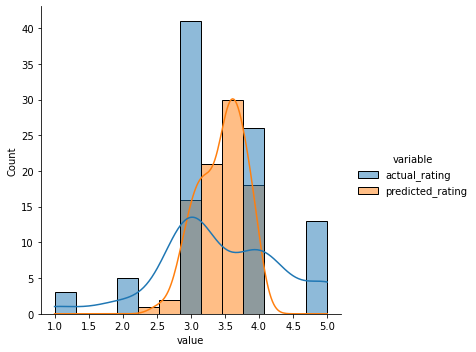

In [322]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

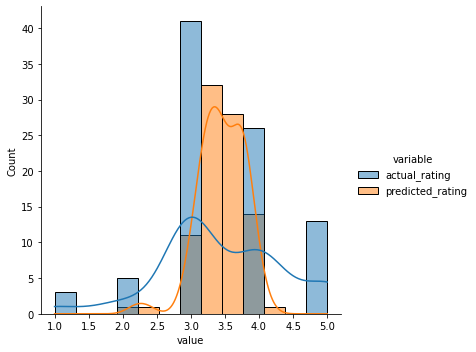

In [323]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [324]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [325]:
#function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [326]:
#A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

#remove _______ and complete the code
# Make list of models
models = [algo_knn_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.772
-----> Recall:  0.414
> k=5, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.772
-----> Recall:  0.42
> k=5, model=KNNBasic
-----> Precision:  0.68
-----> Recall:  0.356
> k=5, model=SVD
-----> Precision:  0.756
-----> Recall:  0.384
> k=5, model=SVD
-----> Precision:  0.745
-----> Recall:  0.382
> k=10, model=KNNBasic
-----> Precision:  0.755
-----> Recall:  0.554
> k=10, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
